In [1]:
## https://github.com/NishantBhavsar/intel-scene-classification/blob/master/resnet_101/resnet-101.ipynb

In [2]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

import os
import gc
from pathlib import Path


from sklearn.metrics import accuracy_score
from IPython.display import FileLink

In [3]:
from fastai import *
from fastai.vision import *
from fastai.callbacks import *

In [4]:
def get_ex(path): return open_image(path)

def plots_f(path, tfms, rows, cols, width, height, **kwargs):
    [get_ex(path).apply_tfms(tfms[0], **kwargs).show(ax=ax) for i,ax in enumerate(plt.subplots(rows,cols,figsize=(width,height))[1].flatten())]

In [5]:
tfms = get_transforms(xtra_tfms=[cutout(n_holes=(1,4), length=(10, 20), p=.75), jitter(magnitude=0.005, p=.25)])
len(tfms)

2

In [6]:
train_df = pd.read_csv('../train.csv')
test_df = pd.read_csv('../test_ApKoW4T.csv')

In [7]:
train_il = ImageList.from_df(df=train_df, cols='image', path='../images/')
test_il = ImageList.from_df(df=test_df, cols='image', path='../images/')

In [8]:
np.random.seed(0)
src1 = (train_il
        .random_split_by_pct()
        .label_from_df(cols='category')
        .add_test(test_il))

/home/shashankwadhwa/env/lib/python3.6/site-packages/fastai/data_block.py:214: UserWarning: `random_split_by_pct` is deprecated, please use `split_by_rand_pct`.
  warn("`random_split_by_pct` is deprecated, please use `split_by_rand_pct`.")


In [9]:
tfms = get_transforms(xtra_tfms=[cutout(n_holes=(1,4), length=(10, 20), p=.75), jitter(magnitude=0.005, p=.25)])     
data1 = (src1
        .transform(tfms, size=150)
        .databunch(path='.', bs=128, num_workers=0)
        .normalize(imagenet_stats))

In [10]:
data1

ImageDataBunch;

Train: LabelList (5002 items)
x: ImageList
Image (3, 150, 150),Image (3, 150, 150),Image (3, 150, 150),Image (3, 150, 150),Image (3, 150, 150)
y: CategoryList
1,2,3,4,1
Path: ../images;

Valid: LabelList (1250 items)
x: ImageList
Image (3, 150, 150),Image (3, 150, 150),Image (3, 150, 150),Image (3, 150, 150),Image (3, 150, 150)
y: CategoryList
1,2,1,1,5
Path: ../images;

Test: LabelList (2680 items)
x: ImageList
Image (3, 150, 150),Image (3, 150, 150),Image (3, 150, 150),Image (3, 150, 150),Image (3, 150, 150)
y: EmptyLabelList
,,,,
Path: ../images

In [11]:
learn1 = cnn_learner(data1, models.resnet101, metrics=[accuracy])

In [12]:
learn1.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


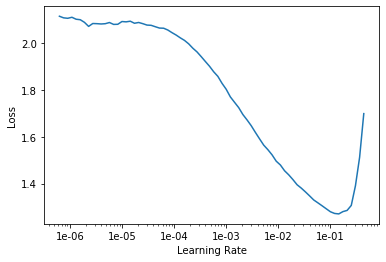

In [13]:
learn1.recorder.plot()

In [14]:
doc(fit_one_cycle)

In [15]:
rn101_stage1_callbacks = [CSVLogger(learn=learn1, filename='rn101-stage-history'), ShowGraph(learn=learn1)]

epoch,train_loss,valid_loss,accuracy,time
0,0.852267,0.499482,0.820800,02:17
1,0.541623,0.949388,0.755200,01:54
2,0.427305,0.447024,0.831200,01:54
3,0.353015,0.337480,0.883200,01:54
4,0.284631,0.273369,0.907200,01:54
5,0.242440,0.274241,0.899200,01:54
6,0.188525,0.196399,0.924800,01:54
7,0.149325,0.192587,0.927200,01:54


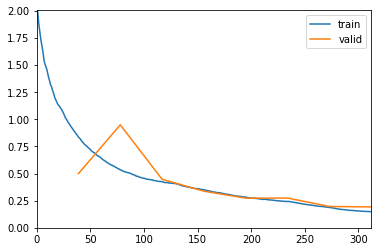

In [16]:
learn1.fit_one_cycle(8, 1e-2, callbacks=rn101_stage1_callbacks, wd=1e-4)

In [17]:
learn1.save('rn101-stage1')

In [18]:
learn1.unfreeze()

In [19]:
learn1.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


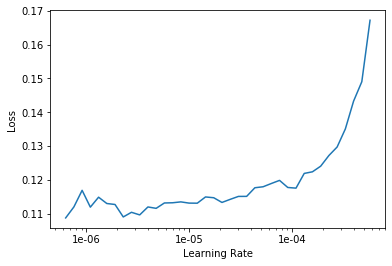

In [20]:
learn1.recorder.plot()

In [21]:
learn1.wd

0.01

In [22]:
rn101_stage2_callbacks = [CSVLogger(learn=learn1, filename='rn101-stage2-history'),ShowGraph(learn=learn1)]

epoch,train_loss,valid_loss,accuracy,time
0,0.117787,0.195058,0.928000,02:18
1,0.115551,0.195122,0.930400,02:18


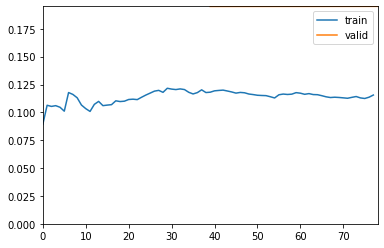

In [23]:
learn1.fit_one_cycle(2, slice(1e-6, 1e-5), callbacks=rn101_stage2_callbacks)

In [24]:
learn1.save('rn101-stage2')

In [25]:
val_preds_tta = learn1.TTA(ds_type=DatasetType.Valid)

In [26]:
accuracy_score(y_pred=val_preds_tta[0].argmax(1).numpy(), y_true=val_preds_tta[1].numpy())

0.9392

In [27]:
val_preds = learn1.get_preds()
accuracy_score(y_pred=val_preds[0].argmax(1).numpy(), y_true=val_preds[1].numpy())

0.9304

In [28]:
test_preds_tta = learn1.TTA(ds_type=DatasetType.Test)
labelled_preds_tta = test_preds_tta[0].argmax(1).numpy()
labelled_preds_tta = [x+1 for x in labelled_preds_tta]

In [29]:
pd.Series(labelled_preds_tta).value_counts()

1    908
2    517
5    512
3    390
4    353
dtype: int64

In [30]:
test_preds = learn1.get_preds(ds_type=DatasetType.Test)
labelled_preds = test_preds[0].argmax(1).numpy()
labelled_preds = [x+1 for x in labelled_preds]

In [31]:
pd.Series(labelled_preds).value_counts()

1    902
5    527
2    510
3    390
4    351
dtype: int64

In [32]:
test_img_names = [Path(i).name for i in learn1.data.test_ds.x.items]

In [33]:
test_pred_df = pd.DataFrame({'image': test_img_names})
test_pred_df['category'] = labelled_preds
test_pred_df.to_csv('k5_sub.csv', index=False)

test_pred_tta_df = pd.DataFrame({'image': test_img_names})
test_pred_tta_df['category'] = labelled_preds_tta
test_pred_tta_df.to_csv('k5_sub_tta.csv', index=False)